# RAPID vs. ECCO: MOC Strength

_Author: Emilio Luz-Ricca_

In this notebook, we explore the similarities and differences in the observed RAPID MOC time series and the ECCO MOC time series. We also inspect the dynamics of individual cells in the RAPID data.

# Setup

Import the needed modules.

In [1]:
import sys
import os
import pickle
sys.path.append('..')

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

import scripts.cell_extraction_26N 

import importlib
importlib.reload(scripts.cell_extraction_26N)

<module 'scripts.cell_extraction_26N' from '/Users/emiliolr/Desktop/GTC-OTP/notebooks/../scripts/cell_extraction_26N.py'>

# Reading in RAPID Array Data and Plotting

Here, we provide basic exploration of RAPID data to get a general sense of the oceanographic patterns contained within the data.

In [2]:
# Reading in the dataset
data_home = "/Users/emiliolr/Google Drive/My Drive/GTC"

rapid_depth = xr.open_dataset(os.path.join(data_home, 'rapid_26N', 'moc_vertical.nc'))
rapid_depth

<xarray.Dataset>
Dimensions:              (time: 13057, depth: 307)
Coordinates:
  * time                 (time) datetime64[ns] 2004-04-02 ... 2022-02-15
  * depth                (depth) float64 0.0 19.87 39.74 ... 5.976e+03 5.995e+03
Data variables:
    stream_function_mar  (depth, time) float64 ...
Attributes:
    Title:                         RAPID streamfunction
    Institution:                   National Oceanography Centre,UK
    Website:                       http://www.rapid.ac.uk/rapidmoc
    Acknowledgement:               The RAPID 26N AMOC monitoring project is f...
    Created_by:                    Ben Moat
    Creation_date:                 08-Sep-2023
    Principle_investigator:        Ben Moat
    Principle_investigator_email:  ben.moat@noc.ac.uk
    DOI:                           doi: 10.5285/04c79ece-3186-349a-e063-6c86a...

In [3]:
# This temp and salinity data may not be useful for calculating potential density since it's
#   aggregated over longitudes...
rapid_temp_sal = xr.open_dataset(os.path.join(data_home, 'rapid_26N', 'ts_gridded.nc'))
rapid_temp_sal

<xarray.Dataset>
Dimensions:          (time: 13057, depth: 242)
Coordinates:
  * time             (time) datetime64[ns] 2004-04-02 ... 2022-02-15
Dimensions without coordinates: depth
Data variables: (12/19)
    pressure         (depth) float64 ...
    TG_west          (depth, time) float64 ...
    SG_west          (depth, time) float64 ...
    TG_wb3           (depth, time) float64 ...
    SG_wb3           (depth, time) float64 ...
    TG_east          (depth, time) float64 ...
    ...               ...
    TG_east_flag     (depth, time) float64 ...
    SG_east_flag     (depth, time) float64 ...
    TG_marwest_flag  (depth, time) float64 ...
    SG_marwest_flag  (depth, time) float64 ...
    TG_mareast_flag  (depth, time) float64 ...
    SG_mareast_flag  (depth, time) float64 ...
Attributes:
    Title:                         RAPID streamfunction
    Institution:                   National Oceanography Centre,UK
    Website:                       http://www.rapid.ac.uk/rapidmoc
    Acknowledgement:               The RAPID 26N AMOC monitoring project is f...
    Created_by:                    Ben Moat
    Creation_date:                 08-Sep-2023
    Principle_investigator:        Ben Moat
    Principle_investigator_email:  ben.moat@noc.ac.uk
    DOI:                           doi: 10.5285/04c79ece-3186-349a-e063-6c86a...

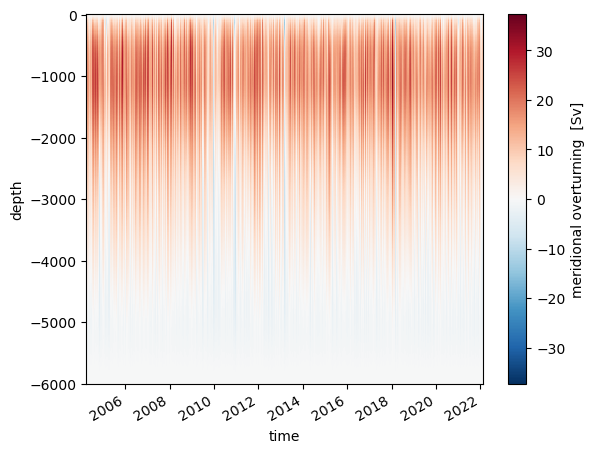

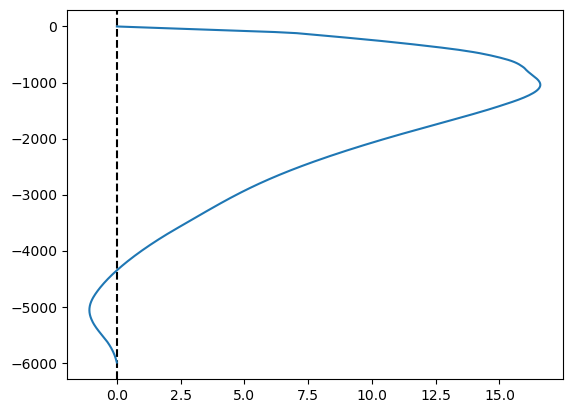

In [4]:
# Pretty sure this is integrating from sea surface down to different depths rather than bottom up...
rapid_flipped = rapid_depth.stream_function_mar.assign_coords({'depth' : -1 * rapid_depth.depth})

plt.axvline(0, color = 'black', linestyle = '--')
plt.plot(rapid_flipped.mean('time'), rapid_flipped.depth)
plt.show()

# Inspecting the Circulation Cells in RAPID

Here, we extracting the depths of maximum circulation for the two vertical cells present at 26.5N (a shallow southwards cell and a deep northwards cell), as well as the switching point between the two cells. A 6-month sliding window is used to smooth out short-term variation.

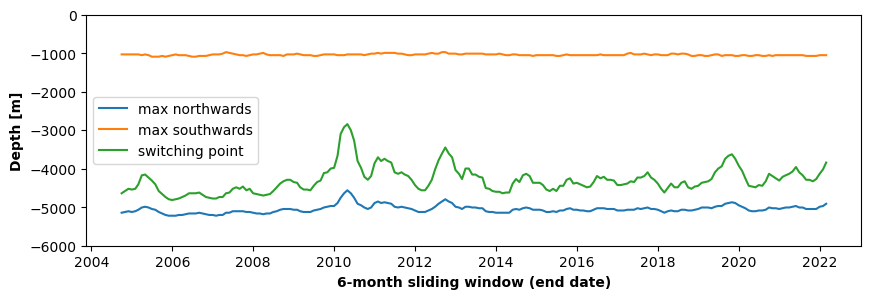

In [8]:
# Calculating the lower/upper cell depths and switch points
min_depths, max_depths, zero_depths, new_time = scripts.cell_extraction_26N.sliding_window_min_max_mix(rapid_flipped, window_size = 6)

# Plot these over time--not quite sure how to interpret time dimension because of windows...
plt.figure(figsize = (10, 3))

plt.plot(new_time, min_depths, label = 'max northwards')
plt.plot(new_time, max_depths, label = 'max southwards')
plt.plot(new_time, zero_depths, label = 'switching point')

plt.ylim(-6000, 0)

plt.ylabel('Depth [m]', weight = 'bold')
plt.xlabel('6-month sliding window (end date)', weight = 'bold')

plt.legend();

# Insepcting the Circulation Cells in ECCO (density-space)

We now compare the above trends seen in observational data (RAPID array) to the cell dynamics in model data (ECCO, density-space streamfunction). We generally find different vertical streamfunction structure in ECCO and are unsure whether this is a modelling issue or an issue with the calculated streamfunction, although we beleive it to be the former since our streamfunction time series values are plausible.

In [7]:
# Grabbing the time values for ECCO data
time = xr.open_dataset(os.path.join(data_home, 'ecco_data_minimal', '26N.nc')).time.values

In [8]:
# Grabbing density mappings
with open(os.path.join(data_home, 'ecco_data_minimal', '26N_original_density_range.pickle'), 'rb') as f:
    density_range = pickle.load(f)

In [9]:
# Loading density-space ECCO data
ecco_streamfunction_density_fp = os.path.join(data_home, 'ecco_data_minimal', '26N_streamfunction_density.pickle')

with open(ecco_streamfunction_density_fp, 'rb') as f:
    ecco_streamfunction_density = pickle.load(f)

# Put into an xarray dataset for convenience
ecco_strf = xr.Dataset(data_vars = {'streamfunction' : (['density_layer', 'time'], ecco_streamfunction_density)}, 
                     coords = {'time' : time, 'density_layer' : density_range})

ecco_strf

<xarray.Dataset>
Dimensions:         (density_layer: 100, time: 312)
Coordinates:
  * time            (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T...
  * density_layer   (density_layer) float64 27.82 27.92 28.02 ... 37.63 37.73
Data variables:
    streamfunction  (density_layer, time) float64 6.305 7.511 ... -0.0 -0.0

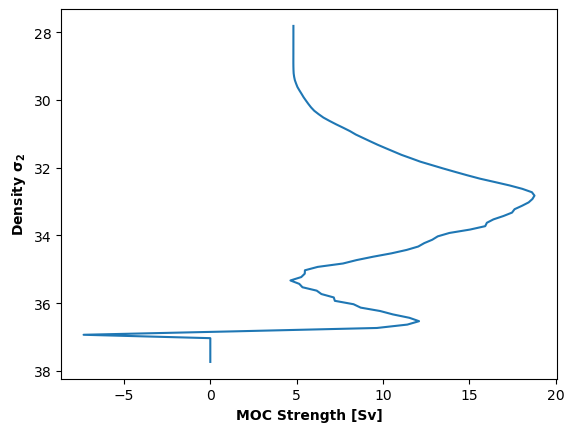

In [10]:
# Plotting streamfunction mean against density layer
plt.plot(ecco_strf.streamfunction.mean('time'), ecco_strf.density_layer)
plt.gca().invert_yaxis()

plt.xlabel('MOC Strength [Sv]', weight = 'bold')
plt.ylabel('Density $\\mathbf{\\sigma_2}$', weight = 'bold');

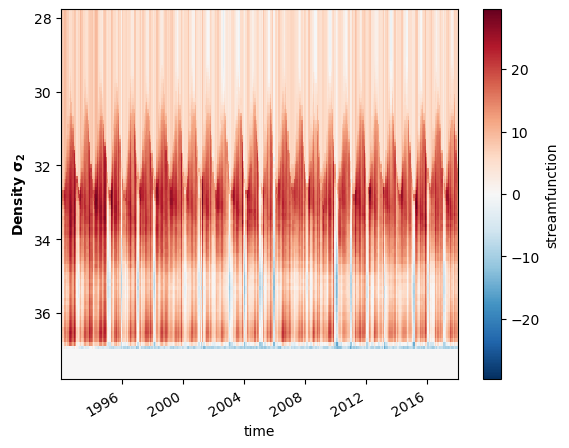

In [11]:
# Plotting streamfunction for density layer vs. time
ecco_strf.streamfunction.plot()
plt.gca().invert_yaxis()

plt.ylabel('Density $\\mathbf{\\sigma_2}$', weight = 'bold');

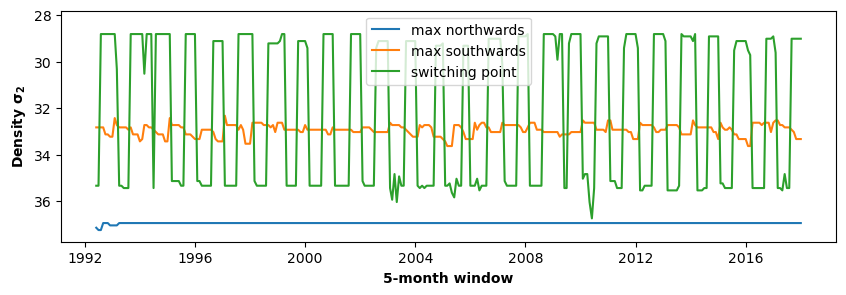

In [12]:
# Applying the same circulation cell dynamics analysis to ECCO density-space streamfunction
min_depths, max_depths, zero_depths, new_time = scripts.cell_extraction_26N.sliding_window_min_max_mix(ecco_strf.streamfunction, 
                                                                                                       depth_coord_name = 'density_layer', 
                                                                                                       remove_above_depth = None,
                                                                                                       ignore_first_last = 10)

plt.figure(figsize = (10, 3))

plt.plot(new_time, min_depths, label = 'max northwards')
plt.plot(new_time, max_depths, label = 'max southwards')
plt.plot(new_time, zero_depths, label = 'switching point')

plt.ylim(density_range.min(), density_range.max())
plt.gca().invert_yaxis()

plt.ylabel('Density $\\mathbf{\\sigma_2}$', weight = 'bold')
plt.xlabel('5-month window', weight = 'bold')

plt.legend();